<a href="https://colab.research.google.com/github/ghanbarifereshteh/singlecolorprj/blob/main/noisysinglecolornew.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from PIL import Image
from numpy import asarray
import shutil
import os

In [2]:
#generate original data
#generate 3 random number and then create a 180*180 image(with single color)
from PIL import Image
def createimage(numberOfimg,sizeOfImage):
  for i in range(numberOfimg):
    red = np.random.choice(range(256), size=1)
    green = np.random.choice(range(256), size=1)
    blue = np.random.choice(range(256), size=1)
    img = Image.new('RGB', (sizeOfImage, sizeOfImage), (red[0], green[0], blue[0]))
    img.save(str(i)+".jpg")

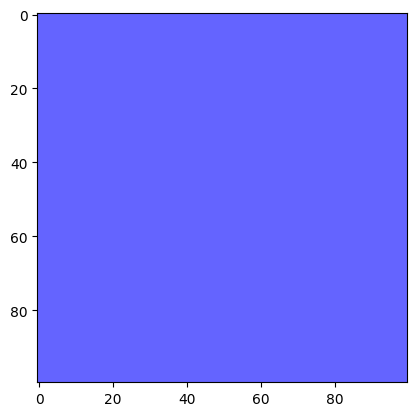

In [ ]:
img = Image.new('RGB', (100, 100), (100, 100, 255))
plt.imshow(img)

In [17]:
#create image whith percent% noise
def createNoisyImage(numberOfImages,sizeOfImage,percent):
  folder = ""
  label = 0
  sum = 0
  os.mkdir("/content/noisyred"+str(percent))
  os.mkdir("/content/noisygreen"+str(percent))
  os.mkdir("/content/noisyblue"+str(percent))
  os.mkdir("/content/noisyblack"+str(percent))
  os.mkdir("/content/noisywhite"+str(percent))
  os.mkdir("/content/noisyyellow"+str(percent))
  os.mkdir("/content/noisypurple"+str(percent))
  numpydata_noisy = np.empty([numberOfImages, sizeOfImage, sizeOfImage, 3], dtype=np.int)
  labels_noisy = np.arange(0,numberOfImages)
  for i in range(0,numberOfImages):
    #before applying noises, we must distinguish the color
    name = str(i)+".jpg"
    img = Image.open(name)
    numpydata_noisy[i] = asarray(img)
    red = numpydata_noisy[i][0][0][0]
    green = numpydata_noisy[i][0][0][1]
    blue = numpydata_noisy[i][0][0][2]
    if(red > green):
      if(red>blue):
        label = 0  #red
        folder = "noisyred"
      elif (red == blue) and (blue==green) and (red == 255):
        label = 1 #white
        folder = "noisywhite"
      elif(red == blue) and (blue==green) and (red != 255):
        label = 2  #black
        folder = "noisyblack"
      elif(red == blue):
        label = 3  #purple
        folder = "noisypurple"
    elif(green>=blue) and (blue > red) :
      label = 5 #green
      folder = "noisygreen"
    elif (red == green) and (blue < red):
      label = 4 #yellow
      folder = "noisyyellow"
    else:
      label = 6 #blue
      folder = "noisyblue"
    labels_noisy[i] = label

    noiseColor=list(np.random.choice(range(256), size=3));
    for j in range(0,sizeOfImage*percent) :
        x=np.random.choice(range(100))
        y=np.random.choice(range(100))
        img.putpixel((x,y), (noiseColor[0], noiseColor[1], noiseColor[2]))
        #plt.imshow(img)
    newName = "noise"+str(percent)+str(i)+".jpg"
    img.save(newName)
    shutil.move("noise"+str(percent)+str(i)+".jpg", str(folder)+str(percent)+"/"+"noise"+str(percent)+str(i)+".jpg")
    numpydata_noisy[i] = asarray(img)
  return labels_noisy,numpydata_noisy

In [14]:
rm -rf noisy*

create 1000 images as a single color dataset

In [15]:
createimage(1000,100)

In [ ]:
ls

In [116]:
mkdir noisyred15

In [117]:
mkdir noisygreen15

In [119]:
mkdir noisyblack15

In [118]:
mkdir noisywhite15

In [120]:
mkdir noisyyellow15

In [121]:
mkdir noisypurple15

In [122]:
mkdir noisyblue15


In [16]:
ls

0.jpg    200.jpg  301.jpg  402.jpg  503.jpg  604.jpg  705.jpg  806.jpg  907.jpg
100.jpg  201.jpg  302.jpg  403.jpg  504.jpg  605.jpg  706.jpg  807.jpg  908.jpg
101.jpg  202.jpg  303.jpg  404.jpg  505.jpg  606.jpg  707.jpg  808.jpg  909.jpg
102.jpg  203.jpg  304.jpg  405.jpg  506.jpg  607.jpg  708.jpg  809.jpg  90.jpg
103.jpg  204.jpg  305.jpg  406.jpg  507.jpg  608.jpg  709.jpg  80.jpg   910.jpg
104.jpg  205.jpg  306.jpg  407.jpg  508.jpg  609.jpg  70.jpg   810.jpg  911.jpg
105.jpg  206.jpg  307.jpg  408.jpg  509.jpg  60.jpg   710.jpg  811.jpg  912.jpg
106.jpg  207.jpg  308.jpg  409.jpg  50.jpg   610.jpg  711.jpg  812.jpg  913.jpg
107.jpg  208.jpg  309.jpg  40.jpg   510.jpg  611.jpg  712.jpg  813.jpg  914.jpg
108.jpg  209.jpg  30.jpg   410.jpg  511.jpg  612.jpg  713.jpg  814.jpg  915.jpg
109.jpg  20.jpg   310.jpg  411.jpg  512.jpg  613.jpg  714.jpg  815.jpg  916.jpg
10.jpg   210.jpg  311.jpg  412.jpg  513.jpg  614.jpg  715.jpg  816.jpg  917.jpg
110.jpg  211.jpg  312.jpg  413.jpg  514.j

when you want to create iamges with 15% noises

In [18]:
(labels_test,numpydata_test) = createNoisyImage(1000,100,15)

<ipython-input-17-24059ec8fe24>:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numpydata_noisy = np.empty([numberOfImages, sizeOfImage, sizeOfImage, 3], dtype=np.int)


In [19]:
ls

0.jpg    213.jpg  327.jpg  440.jpg  554.jpg  668.jpg  781.jpg  895.jpg
100.jpg  214.jpg  328.jpg  441.jpg  555.jpg  669.jpg  782.jpg  896.jpg
101.jpg  215.jpg  329.jpg  442.jpg  556.jpg  66.jpg   783.jpg  897.jpg
102.jpg  216.jpg  32.jpg   443.jpg  557.jpg  670.jpg  784.jpg  898.jpg
103.jpg  217.jpg  330.jpg  444.jpg  558.jpg  671.jpg  785.jpg  899.jpg
104.jpg  218.jpg  331.jpg  445.jpg  559.jpg  672.jpg  786.jpg  89.jpg
105.jpg  219.jpg  332.jpg  446.jpg  55.jpg   673.jpg  787.jpg  8.jpg
106.jpg  21.jpg   333.jpg  447.jpg  560.jpg  674.jpg  788.jpg  900.jpg
107.jpg  220.jpg  334.jpg  448.jpg  561.jpg  675.jpg  789.jpg  901.jpg
108.jpg  221.jpg  335.jpg  449.jpg  562.jpg  676.jpg  78.jpg   902.jpg
109.jpg  222.jpg  336.jpg  44.jpg   563.jpg  677.jpg  790.jpg  903.jpg
10.jpg   223.jpg  337.jpg  450.jpg  564.jpg  678.jpg  791.jpg  904.jpg
110.jpg  224.jpg  338.jpg  451.jpg  565.jpg  679.jpg  792.jpg  905.jpg
111.jpg  225.jpg  339.jpg  452.jpg  566.jpg  67.jpg   793.jpg  906.jpg
112.jpg  

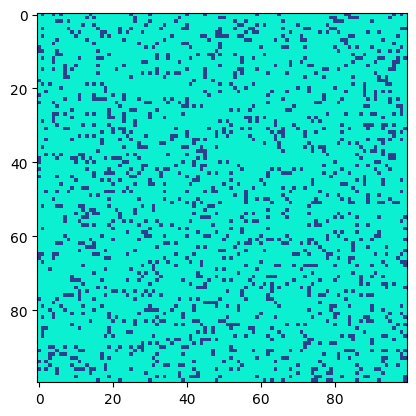

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(numpydata_test[794])

when you want to create iamges with 25% noises

In [98]:
rm -rf noisy*

In [99]:
mkdir noisyred25

In [100]:
mkdir noisygreen25

In [101]:
mkdir noisyblack25

In [103]:
mkdir noisyblue25

mkdir: cannot create directory ‘noisyblue25’: File exists


In [107]:
mkdir noisyyellow25

In [104]:
mkdir noisypurple25

In [105]:
mkdir noisywhite25

In [108]:
(labels_test,numpydata_test) = createNoisyImage(1000,100,25)

<ipython-input-31-7adefc49a481>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numpydata_noisy = np.empty([numberOfImages, sizeOfImage, sizeOfImage, 3], dtype=np.int)


In [69]:
ls

noise25938.jpg


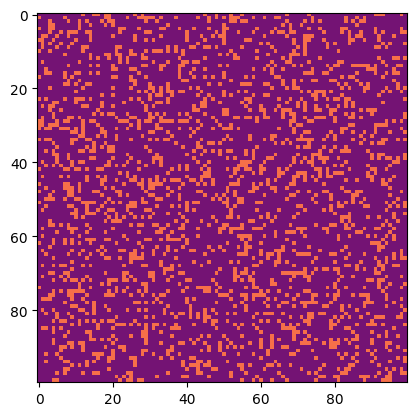

In [70]:
import matplotlib.pyplot as plt
plt.imshow(numpydata_test[938])

In [142]:
rm -rf noisy*

In [153]:
mkdir noisyblue45

mkdir: cannot create directory ‘noisyblue45’: File exists


In [152]:
mkdir noisyblack45

mkdir: cannot create directory ‘noisyblack45’: File exists


In [151]:
mkdir noisyred45

In [150]:
mkdir noisygreen45

mkdir: cannot create directory ‘noisygreen45’: File exists


In [149]:
mkdir noisyyellow45

mkdir: cannot create directory ‘noisyyellow45’: File exists


In [148]:
mkdir noisywhite45

In [147]:
mkdir noisypurple45

In [154]:
(labels_test,numpydata_test) = createNoisyImage(1000,100,45)

<ipython-input-31-7adefc49a481>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numpydata_noisy = np.empty([numberOfImages, sizeOfImage, sizeOfImage, 3], dtype=np.int)


In [ ]:
ls

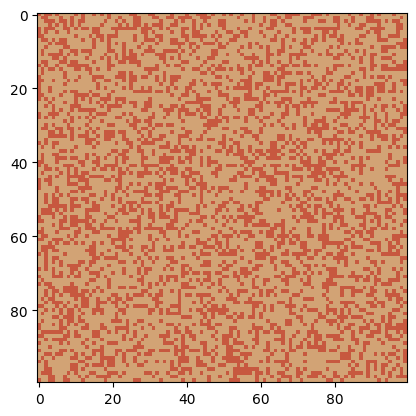

In [161]:
import matplotlib.pyplot as plt
plt.imshow(numpydata_test[673])

In [186]:
ls


0.jpg    213.jpg  327.jpg  440.jpg  554.jpg  668.jpg  781.jpg  895.jpg
100.jpg  214.jpg  328.jpg  441.jpg  555.jpg  669.jpg  782.jpg  896.jpg
101.jpg  215.jpg  329.jpg  442.jpg  556.jpg  66.jpg   783.jpg  897.jpg
102.jpg  216.jpg  32.jpg   443.jpg  557.jpg  670.jpg  784.jpg  898.jpg
103.jpg  217.jpg  330.jpg  444.jpg  558.jpg  671.jpg  785.jpg  899.jpg
104.jpg  218.jpg  331.jpg  445.jpg  559.jpg  672.jpg  786.jpg  89.jpg
105.jpg  219.jpg  332.jpg  446.jpg  55.jpg   673.jpg  787.jpg  8.jpg
106.jpg  21.jpg   333.jpg  447.jpg  560.jpg  674.jpg  788.jpg  900.jpg
107.jpg  220.jpg  334.jpg  448.jpg  561.jpg  675.jpg  789.jpg  901.jpg
108.jpg  221.jpg  335.jpg  449.jpg  562.jpg  676.jpg  78.jpg   902.jpg
109.jpg  222.jpg  336.jpg  44.jpg   563.jpg  677.jpg  790.jpg  903.jpg
10.jpg   223.jpg  337.jpg  450.jpg  564.jpg  678.jpg  791.jpg  904.jpg
110.jpg  224.jpg  338.jpg  451.jpg  565.jpg  679.jpg  792.jpg  905.jpg
111.jpg  225.jpg  339.jpg  452.jpg  566.jpg  67.jpg   793.jpg  906.jpg
112.jpg  

In [23]:
batch_size = 20
img_height = 100
img_width = 100
data_dir = "/content"

In [24]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1000 files belonging to 8 classes.
Using 200 files for validation.


In [25]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1000 files belonging to 8 classes.
Using 800 files for training.


In [26]:
from tensorflow.keras import datasets, layers, models
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [27]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

In [ ]:
model.summary()


In [181]:
ls

0.jpg    214.jpg  329.jpg  443.jpg  558.jpg  672.jpg  787.jpg  900.jpg
100.jpg  215.jpg  32.jpg   444.jpg  559.jpg  673.jpg  788.jpg  901.jpg
101.jpg  216.jpg  330.jpg  445.jpg  55.jpg   674.jpg  789.jpg  902.jpg
102.jpg  217.jpg  331.jpg  446.jpg  560.jpg  675.jpg  78.jpg   903.jpg
103.jpg  218.jpg  332.jpg  447.jpg  561.jpg  676.jpg  790.jpg  904.jpg
104.jpg  219.jpg  333.jpg  448.jpg  562.jpg  677.jpg  791.jpg  905.jpg
105.jpg  21.jpg   334.jpg  449.jpg  563.jpg  678.jpg  792.jpg  906.jpg
106.jpg  220.jpg  335.jpg  44.jpg   564.jpg  679.jpg  793.jpg  907.jpg
107.jpg  221.jpg  336.jpg  450.jpg  565.jpg  67.jpg   794.jpg  908.jpg
108.jpg  222.jpg  337.jpg  451.jpg  566.jpg  680.jpg  795.jpg  909.jpg
109.jpg  223.jpg  338.jpg  452.jpg  567.jpg  681.jpg  796.jpg  90.jpg
10.jpg   224.jpg  339.jpg  453.jpg  568.jpg  682.jpg  797.jpg  910.jpg
110.jpg  225.jpg  33.jpg   454.jpg  569.jpg  683.jpg  798.jpg  911.jpg
111.jpg  226.jpg  340.jpg  455.jpg  56.jpg   684.jpg  799.jpg  912.jpg
112.jpg

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['acc'])

history = model.fit(numpydata_test, labels_test, epochs=10)

Epoch 1/10
32/32 [==============================] - 134s 4s/step - loss: 164.3902 - acc: 0.4600
Epoch 2/10
32/32 [==============================] - 130s 4s/step - loss: 1.9985 - acc: 0.4850
Epoch 3/10
27/32 [========================>.....] - ETA: 20s - loss: 1.7552 - acc: 0.5671

result of validation on images with 15% noises

Epoch 1/10
32/32 [==============================] - 2s 14ms/step - loss: 23.3167 - acc: 0.5580
Epoch 2/10
32/32 [==============================] - 0s 13ms/step - loss: 1.1656 - acc: 0.5690
Epoch 3/10
32/32 [==============================] - 0s 13ms/step - loss: 0.9001 - acc: 0.5720
Epoch 4/10
32/32 [==============================] - 0s 14ms/step - loss: 0.9191 - acc: 0.6100
Epoch 5/10
32/32 [==============================] - 0s 14ms/step - loss: 1.4659 - acc: 0.4780
Epoch 6/10
32/32 [==============================] - 0s 14ms/step - loss: 1.4780 - acc: 0.6610
Epoch 7/10
32/32 [==============================] - 0s 14ms/step - loss: 1.2863 - acc: 0.6870
Epoch 8/10
32/32 [==============================] - 1s 16ms/step - loss: 1.1594 - acc: 0.6840
Epoch 9/10
32/32 [==============================] - 0s 13ms/step - loss: 0.9598 - acc: 0.6970
Epoch 10/10
32/32 [==============================] - 0s 13ms/step - loss: 0.8754 - acc: 0.6960


result of validation on images with 25% noises

Epoch 1/10
32/32 [==============================] - 2s 14ms/step - loss: 50.5913 - acc: 0.5270
Epoch 2/10
32/32 [==============================] - 0s 13ms/step - loss: 1.1217 - acc: 0.6170
Epoch 3/10
32/32 [==============================] - 0s 12ms/step - loss: 0.7228 - acc: 0.7160
Epoch 4/10
32/32 [==============================] - 0s 12ms/step - loss: 0.6273 - acc: 0.7380
Epoch 5/10
32/32 [==============================] - 0s 13ms/step - loss: 0.6090 - acc: 0.7480
Epoch 6/10
32/32 [==============================] - 0s 13ms/step - loss: 0.5925 - acc: 0.7560
Epoch 7/10
32/32 [==============================] - 0s 12ms/step - loss: 0.5152 - acc: 0.7970
Epoch 8/10
32/32 [==============================] - 0s 13ms/step - loss: 0.4877 - acc: 0.8060
Epoch 9/10
32/32 [==============================] - 0s 13ms/step - loss: 0.6852 - acc: 0.7500
Epoch 10/10
32/32 [==============================] - 0s 13ms/step - loss: 0.5254 - acc: 0.7950

result of validation on images with 45% noises

Epoch 1/10
32/32 [==============================] - 3s 16ms/step - loss: 29.4900 - acc: 0.3580
Epoch 2/10
32/32 [==============================] - 0s 14ms/step - loss: 1.2315 - acc: 0.4990
Epoch 3/10
32/32 [==============================] - 0s 14ms/step - loss: 1.1706 - acc: 0.4840
Epoch 4/10
32/32 [==============================] - 0s 14ms/step - loss: 1.1235 - acc: 0.4900
Epoch 5/10
32/32 [==============================] - 0s 14ms/step - loss: 1.1577 - acc: 0.4790
Epoch 6/10
32/32 [==============================] - 0s 13ms/step - loss: 2.0312 - acc: 0.3690
Epoch 7/10
32/32 [==============================] - 0s 13ms/step - loss: 1.8527 - acc: 0.3870
Epoch 8/10
32/32 [==============================] - 0s 12ms/step - loss: 1.6437 - acc: 0.3980
Epoch 9/10
32/32 [==============================] - 0s 13ms/step - loss: 1.4801 - acc: 0.3980
Epoch 10/10
32/32 [==============================] - 0s 13ms/step - loss: 1.3650 - acc: 0.3980


In [184]:
rm -rf tf

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label = 'val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(numpydata_test,  labels_test, verbose=2)